<a href="https://colab.research.google.com/github/Alxmis/QR-decomposition/blob/Splines_coeffs_founder/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import poly
from sympy.abc import x
import cmath
import math
import scipy

# Task for 6-7

In [13]:
def simple_qr(matrix: np.array) -> np.array:
    q, r = np.linalg.qr(matrix)
    for _ in range(1_000):
        matrix = r @ q
        q, r = np.linalg.qr(matrix)
    return matrix

def get_roots(matrix: np.array) -> np.array:
    n = matrix.shape[0]
    approximated = np.vstack([simple_qr(matrix), np.zeros(n)])
    determinated = approximated.round(5)

    roots = np.zeros(n)
    i = 0
    while i < n:
        root = approximated[i][i]
        detr = determinated[i+1][i]
        if detr == 0:
            roots[i] = root
        else:
            # select block
            p = 1
            for j in range(i+1, n):
                if determinated[j+1][j] == 0:
                    break
                p += 1
            block = approximated[i:i+p+1, i:i+p+1]
            # p == 1 -> our target
            if p == 1:
                D = (block[1][1] + block[0][0])**2 - 4*(block[0][0]*block[1][1]-block[0][1]*block[1][0])
                # convert type
                if D < 0:
                    roots = roots.astype(complex)
                    l1 = (block[1][1] + block[0][0] - cmath.sqrt(D))/2
                    l2 = (block[1][1] + block[0][0] + cmath.sqrt(D))/2
                else:
                    l1 = (block[1][1] + block[0][0] - math.sqrt(D))/2
                    l2 = (block[1][1] + block[0][0] + math.sqrt(D))/2
                roots[i + p - 1] = l1
                roots[i + p - 0] = l2
            # p != 1 -> not our target
            else:
                __roots = np.linalg.eigvals(block)
                for j in range(p+1):
                    roots[i + j] = __roots[j]
            print(block)
            i += p
        i += 1
    return roots


In [14]:
n = 3
omega = 50

matrix = np.random.randint(-omega, omega, (n, n))
print(f"Initial matrix:\n{matrix}")
approximated_matrix = simple_qr(matrix)
print(f"Approximated matrix:\n{approximated_matrix.round(5)}")
roots = get_roots(matrix)
print(f"Function`s roots:\n{roots}")
eigen = np.linalg.eigvals(matrix)
print(f"True eigenvalues:\n{eigen}")

Initial matrix:
[[-37  11  31]
 [-28  24 -12]
 [ -2 -22 -39]]
Approximated matrix:
[[-3.094709e+01 -3.212309e+01  2.586970e+01]
 [ 1.305165e+01 -4.869177e+01 -4.581000e-02]
 [ 0.000000e+00 -0.000000e+00  2.763887e+01]]
[[-30.9470945  -32.12308848]
 [ 13.05164707 -48.69177309]]
Function`s roots:
[-39.8194338-18.45374783j -39.8194338+18.45374783j
  27.6388676 +0.j        ]
True eigenvalues:
[ 27.6388676 +0.j         -39.8194338+18.45374783j
 -39.8194338-18.45374783j]


# Task for 8

In [15]:
def hauseholder_qr(A):
    m, n = A.shape
    Q = np.eye(m)
    for i in range(n - (m == n)):
        H = np.eye(m)
        H[i:, i:] = make_householder(A[i:, i])
        Q = np.dot(Q, H)
        A = np.dot(H, A)
    return Q, A

def make_householder(a):
    v = a / (a[0] + np.copysign(np.linalg.norm(a), a[0]))
    v[0] = 1
    H = np.eye(a.shape[0])
    H -= (2 / np.dot(v, v)) * np.dot(v[:, None], v[None, :])
    return H

In [16]:
q_h, r_h = hauseholder_qr(matrix)
q, r = np.linalg.qr(matrix)

In [17]:
print(f'Householder\nQ:{q_h}\nR:{r_h}')
print(f'Numpy\nQ:{q}\nR:{r}')

Householder
Q:[[-0.79666668  0.25816861 -0.54650817]
 [-0.60288289 -0.40384035  0.68807353]
 [-0.04306306  0.87764568  0.47737159]]
R:[[ 4.64435141e+01 -2.22851354e+01 -1.57826128e+01]
 [-3.22221854e-15 -2.61605187e+01 -2.13788703e+01]
 [ 6.63060662e-15  3.77336068e-15 -4.38161276e+01]]
Numpy
Q:[[-0.79666668  0.25816861 -0.54650817]
 [-0.60288289 -0.40384035  0.68807353]
 [-0.04306306  0.87764568  0.47737159]]
R:[[ 46.44351408 -22.28513541 -15.7826128 ]
 [  0.         -26.16051872 -21.37887029]
 [  0.           0.         -43.8161276 ]]


In [18]:
q_h.round(5) == q.round(5), r_h.round(5) == r.round(5)

(array([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]),
 array([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]))

# Task for 10 Splines

In [19]:
EPS = 1e-2

In [20]:
def TDMA(M, B, n):
    coeff = np.array([[0 for _ in range(2)] for i in range(n)], dtype=float)
    root = np.array([0 for _ in range(n)], dtype=float)
    temp_y = np.array([0 for _ in range(n)], dtype=float)

    for i in range(n):
        if i == 0:
            temp_y[i] = M[i][i]
            coeff[i][0] = -M[i][1] / temp_y[i]
            coeff[i][1] = B[i] / temp_y[i]
            continue
        elif i == n - 1:
            temp_y[i] = M[i][i] + M[i][i - 1] * coeff[i - 1][0]
            coeff[i][1] = (B[i] - M[i][i - 1] * coeff[i - 1][1]) / temp_y[i]
            continue
        temp_y[i] = M[i][i] + M[i][i - 1] * coeff[i - 1][0]
        coeff[i][0] = -M[i][i + 1] / temp_y[i]
        coeff[i][1] = (B[i] - M[i][i - 1] * coeff[i - 1][1]) / temp_y[i]

    for i in range(n - 1, 0 - 1, -1):
        if i == n - 1:
            root[i] = coeff[i][1]
            continue
        root[i] = coeff[i][0] * root[i + 1] + coeff[i][1]

    return root

def get_gammas(X, Y, G, n):
    for i in range(n - 2):
        for j in range(n - 2):
            if j == i - 1 or j == i + 1:
                G[i][j] = (X[i + 1] - X[i]) / 6.0
            elif j == i:
                G[i][j] = ((X[i + 1] - X[i]) + (X[i + 2] - X[i + 1])) / 3.0
            else:
                G[i][j] = 0

    B = np.array([0 for _ in range(n - 2)], dtype=float)
    for i in range(n - 2):
        B[i] = ((Y[i + 2] - Y[i + 1]) / (X[i + 2] - X[i + 1])) \
               - ((Y[i + 1] - Y[i]) / (X[i + 1] - X[i]))

    temp_gammas = TDMA(G, B, n - 2)
    gammas = np.array([0 for _ in range(n)], dtype=float)
    gammas[0], gammas[n - 1] = g0, gn
    for i in range(1, n - 1):
        gammas[i] = temp_gammas[i - 1]

    return gammas

def get_point(X, Y, gammas, x0, i):
    G = gammas
    w = X[i + 1] - X[i]
    return Y[i] * ((X[i + 1] - x0) / w) \
            + Y[i + 1] * ((x0 - X[i]) / w) \
            + G[i] * ((X[i + 1] - x0)**3 - w**2 * (X[i + 1] - x0)) / (6.0 * w) \
            + G[i + 1] * ((x0 - X[i])**3 - w**2 * (x0 - X[i])) / (6.0 * w)

def get_segment(X, x0, n):
    segment = -1
    for i in range(n - 1):
        if X[i] <= x0 and x0 <= X[i + 1]:
            segment = i
            break

    if segment != - 1:
        return segment
    else:
        print("Splines do not have intersection point")
        exit(2)

def get_poly_coeffs(X, Y, gammas, i):
    G = gammas
    w = X[i + 1] - X[i]
    polynom = poly(Y[i] * ((X[i + 1] - x) / w) \
             + Y[i + 1] * ((x - X[i]) / w) \
             + G[i] * ((X[i + 1] - x) ** 3 - w ** 2 * (X[i + 1] - x)) / (6.0 * w) \
             + G[i + 1] * ((x - X[i]) ** 3 - w ** 2 * (x - X[i])) / (6.0 * w), x)
    return polynom.all_coeffs()

def get_intersection_segments(X1, Y1, X2, Y2, gammas_1, gammas_2, n):
    left_boarder, right_boarder = max(X1[0], X2[0]), min(X1[-1], X2[-1])
    x0 = left_boarder
    segment_1, segment_2 = -1, -1
    while x0 < right_boarder:
        segment_1 = get_segment(X1, x0, n)
        segment_2 = get_segment(X2, x0, n)
        if abs(get_point(X1, Y1, gammas_1, x0, segment_1) - get_point(X2, Y2, gammas_2, x0, segment_2)) < EPS:
            break

        x0 += 0.001

    return segment_1, segment_2

In [21]:
X1 = np.loadtxt('X1.txt', dtype=float)
X2 = np.loadtxt('X2.txt', dtype=float)
Y1 = np.loadtxt('Y1.txt', dtype=float)
Y2 = np.loadtxt('Y2.txt', dtype=float)
n = X1.shape[0]

g0 = gn = 0
G = np.array([[0 for _ in range(n - 2)] for i in range(n - 2)], dtype=float)
gammas_1 = get_gammas(X1, Y1, G, n)
gammas_2 = get_gammas(X2, Y2, G, n)


inter_segment_1, inter_segment_2 = get_intersection_segments(X1, Y1, X2, Y2, gammas_1, gammas_2, n)


coeffs_1 = np.array(get_poly_coeffs(X1, Y1, gammas_1, inter_segment_1))
coeffs_2 = np.array(get_poly_coeffs(X2, Y2, gammas_2, inter_segment_2))
coefficients = coeffs_1 - coeffs_2

In [22]:
H = np.array([[0, 0, -coefficients[3] / coefficients[0]],
              [1, 0, -coefficients[2] / coefficients[0]],
              [0, 1, -coefficients[1] / coefficients[0]]])
roots = get_roots(H)
root_num = roots.shape[0]
for i in range(root_num):
    if (roots[i] >= max(X1[inter_segment_1], X2[inter_segment_2]) and roots[i] <= min(X1[inter_segment_1+1], X2[inter_segment_2+1])):
        print("Intersection point:", roots[i], get_point(X1, Y1, gammas_1, roots[i], inter_segment_1))

Intersection point: 2.035575834248613 3.5947057699136833


# Task for 10 Gram_Schmidt

In [23]:
def gram_orthon(matrix):
    M = gram_orthog(matrix)
    n_cols = M.shape[1]
    for i in range(n_cols):
        M[:, i] = M[:, i] / np.linalg.norm(M[:, i])
    return M

def gram_orthog(matrix):
    n_rows, n_cols = matrix.shape
    M = np.zeros((n_rows, n_cols))
    for i in range(n_cols):
        m = matrix[:, i].astype('float64')
        for j in range(i):
            m -= np.dot(m, M[:, j]) / np.dot(M[:, j], M[:, j]) * M[:, j]
        M[:, i] = m
    return M

def gram_R(matrix, Q):
    n_rows, n_cols = matrix.shape
    R = np.zeros((n_rows, n_cols))
    for j in range(n_cols):
        for i in range(j + 1):
            R[i, j] = np.dot(Q[:, i], matrix[:, j])
    return R

def gram_qr(matrix):
  Q = gram_orthon(matrix)
  R = gram_R(matrix, Q)
  return Q, R

In [24]:
q_g, r_g = gram_qr(matrix)
q, r = np.linalg.qr(matrix)

In [25]:
print(f'Gram\nQ:{q_g}\nR:{r_g}\nQR:{q_g@r_g}')
print(f'Numpy\nQ:{q}\nR:{r}\nqr:{q@r}')

Gram
Q:[[-0.79666668 -0.25816861  0.54650817]
 [-0.60288289  0.40384035 -0.68807353]
 [-0.04306306 -0.87764568 -0.47737159]]
R:[[ 46.44351408 -22.28513541 -15.7826128 ]
 [  0.          26.16051872  21.37887029]
 [  0.           0.          43.8161276 ]]
QR:[[-37.  11.  31.]
 [-28.  24. -12.]
 [ -2. -22. -39.]]
Numpy
Q:[[-0.79666668  0.25816861 -0.54650817]
 [-0.60288289 -0.40384035  0.68807353]
 [-0.04306306  0.87764568  0.47737159]]
R:[[ 46.44351408 -22.28513541 -15.7826128 ]
 [  0.         -26.16051872 -21.37887029]
 [  0.           0.         -43.8161276 ]]
qr:[[-37.  11.  31.]
 [-28.  24. -12.]
 [ -2. -22. -39.]]


## Stability: Gram Schmidt VS Hauseholder

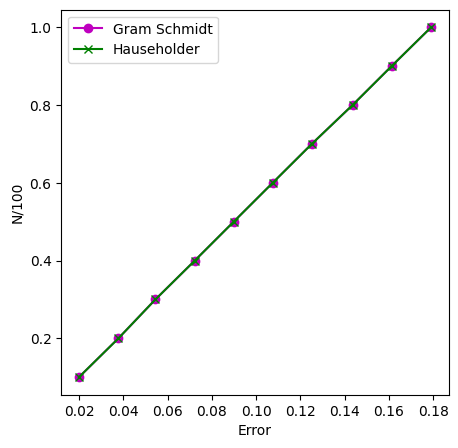

In [26]:
import matplotlib.pyplot as plt

def measure_stability(init_matrix, pert_matrix, gram_mode=1):
  if gram_mode == 1:
    Q_i, R_i = gram_qr(init_matrix)
    Q_p, R_p = gram_qr(pert_matrix)
    error = np.linalg.norm(Q_i @ R_i - Q_p @ R_p)
    return error
  else:
    Q_i, R_i = hauseholder_qr(init_matrix)
    Q_p, R_p = hauseholder_qr(pert_matrix)
    error = np.linalg.norm(Q_i @ R_i - Q_p @ R_p)
    return error

N = 100
N_arr = np.array([x for x in range(10, N + 10, 10)])
G = [[] for _ in range(10, N + 10, 10)]
H = [[] for _ in range(10, N + 10, 10)]
eps = 1e-3
omega = 50
iter = 10
for n in range(10, N + 10, 10):
  max_g, max_h = 0, 0
  for i in range(iter):
    initial_matrix = np.random.randint(-omega, omega, (n, n))
    perturbated_matrix = np.random.randint(-3, 3, (n, n))*eps + initial_matrix

    err_g = measure_stability(initial_matrix, perturbated_matrix, gram_mode=1)
    err_h = measure_stability(initial_matrix, perturbated_matrix, gram_mode=0)
    if err_g > max_g: max_g = err_g
    if err_h > max_h: max_h = err_h

  G[int(n/10) - 1].append(max_g)
  H[int(n/10 - 1)].append(max_h)

fig, axs = plt.subplots(figsize=(5, 5))
plt.plot(G, N_arr/100, "-om", label="Gram Schmidt")
plt.plot(H, N_arr/100, "-xg", label='Hauseholder')
plt.ylabel("N/100")
plt.xlabel("Error")
plt.legend()
plt.show()


# Multihreading

In [27]:
import threading

In [28]:
cache = {}

def column(a: np.array, i: int) -> np.array:
    return np.array([x[i] for x in a])

def row(a: np.array, i: int) -> np.array:
    return a[i]

def dot(a: np.array, b: np.array, i: int) -> np.array:
    if isinstance(b, list):
        result = [0] * len(b)
        for j, data in enumerate(b):
            result[j] = dot(a, data, i)
        cache[i] = np.array(result)
    else:
        return np.sum(a * b.T)

def dot_product_threaded(a: np.array, b: np.array):
    assert a.shape[1] == b.shape[0]
    num_of_threads = a.shape[1]
    threads = []
    global cache
    cache = {}
    for t in range(num_of_threads):
        thread = threading.Thread(
            target=dot,
            args=(row(a, t), [column(b, i) for i in range(b.shape[1])], t)
        )
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    return np.array([cache[i] for i in range(num_of_threads)])

def qr_threaded(A: np.array, num_of_threads: int) -> np.array:
    n = A.shape[0]
    if n < num_of_threads:
        print('Number of threads is more than shape of matrix, changing...')
        num_of_threads = n
    blocks = []
    for i in range(num_of_threads):


SyntaxError: ignored

In [ ]:
n = 200
matrix_a = np.random.randint(-50, 50, (n, n))
matrix_b = np.random.randint(-50, 50, (n, n))
matrix_a, matrix_b

In [ ]:
dot_product_threaded(matrix_a, matrix_b)

In [ ]:
matrix_a @ matrix_b

In [ ]:
def hauseholder_qr_threaded(A):
    m, n = A.shape
    Q = np.eye(m)
    for i in range(n - (m == n)):
        H = np.eye(m)
        H[i:, i:] = make_householder(A[i:, i])
        Q = dot_product_threaded(Q, H)
        A = dot_product_threaded(H, A)
    return Q, A

In [ ]:
n = 3
omega = 50

matrix = np.random.randint(-omega, omega, (n, n))

In [ ]:
q_t, r_t = hauseholder_qr_threaded(matrix)
q, r = hauseholder_qr(matrix)

In [ ]:
q_t, q